# Predicting Job Satisfaction of Software Developers
In this research project a classification model will be created that tries to predict the Job Satisfaction of Software Developers using the survey results from the Stack Overflow survey of 2018.<br>
The Job Satisfaction has 7 levels:
1. Extremely satisfied
2. Moderately satisfied
3. Slightly satisfied
4. Neither satisfied nor dissatisfied
5. Slightly dissatisfied
6. Moderately dissatisfied
7. Extremely dissatisfied

## 1. Describing the dataset
[Stack Overflow](https://stackoverflow.com/) is a website where you can ask and answer software related questions. It is a platform where millions of programmers, software developers, software engineers, etc. meet every day to learn form each other. Stack Overflow itself is aware of the enormous popularity of their platform and for this reason they keep a annual survey to get general insight about the average software engineer in relation to his/her field of work.

Every year the results of the survey will get published on their website (cleaned and in csv format). Multiple datasets (one for each year since 2015) are available for analysis. For this project the survey results of 2018 will be used exclusively. The main reason for this choice is recency and the completeness of the results. The 2018 survey results were filled in by around 100.000 software developers, most of which answered 129 different questions. These questions are about job satisfaction, salary, favourite programming languages, weekly exercise, company size, etc. This large variety of questions provides a source of interesting research opportunities.

**Source of the dataset**<br />
Stack Overflow Developer Survey 2018 (186 MB): https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey


**Data description:**<br />
The Stack Overflow survey results of 2018 has in total 98855 rows and 129 columns. Some of these columns consist of only numerical data like 'Salary' and 'ConvertedSalary', while all the other columns are categorical (nominal or ordinal). The categorical columns are devidable over three data types:
- Values denoted in text. E.g. 'Yes', 'No', 'United States', 'Employed part-time', etc.
- Values denoted in ';' seperated lists. E.g. 'Python;Java;C#', 'Windows;Linux;, etc.
- Values denoted in numbers. E.g. 1, 2, 3, 4, etc. (for rankings)

Textual input can't be interpreted easily by the average Machine Learning algorithm. Therefore, preprocessing of the original dataset is needed, so it can be used for further analysis. A [notebook](./dataset_preprocessing.ipynb) is created that is dedicted to preprocessing the Stack Overflow survey dataset in the following ways:
- Drop rows with missing values in the column 'JobSatisfaction'. The column 'JobSatisfaction' is the target value that will be used for analysis. It is not desirable to have missing values for a target feature, because the value NaN doesn't refer to valid classification value.
- Drop unimportant columns. Some columns can be left out because they have no correlation with the target column 'JobSatisfaction', are redundant or have too many missing values (35% or higher).
- Preprocess values dentoed in ';' seperated lists. List values such as 'Python;Java;C#' can't be used as input for a Machine Learning algorithm. First, the value has to be numerical. Second, numerification of the ';' value as is will result a unique class for every unique list. It is instead needed to get a unique class for every language present in the list.
- Encode text to numerical values. Text isn't easy to interpret for Machine Learning algorithms. To solve this problem all text-formatted values will be converted to numerical values. Nominal values are encoded with One Hot Encoding, while ordinal values are encoded with manually added labels.
- Impute missing values. A lot of data is missing, this missing data can be imputed with statistical values (e.g. mean, mode, etc.)

The above steps will result in a preprocessed data set with 69276 rows and 623 columns.<br />
The data will be tranformed as follows:<br />

| Student | Programming Language | Country        |
|:-------:|:--------------------:|:--------------:|
| Yes     | Python;Java;C#       | Kenya          |
| No      | Python;C#            | United Kingdom |
| Yes     | Java;C#              | United States  |

| Student | Python | Java | C# | Country%Kenya | Country%United Kingdom | Country%United States |
|:-------:|:------:|:----:|:--:|:-------------:|:----------------------:|:---------------------:|
| 1       | 1      | 1    | 1  | 1             | 0                      | 0                     |
| 0       | 1      | 0    | 1  | 0             | 1                      | 0                     |
| 1       | 0      | 1    | 1  | 0             | 0                      | 1                     |

## 2. Defining research
Research will be conducted on the job satisfaction of software developers. The dataset, as described above, will be used to create a classifaction model that predicts the job statisfaction of software developers. The following research question will be answered:

**Can an accurate model be created, given the features denoted in the survey, to predict the job satisfaction of software developers?**

The model will be seen as accurate if at least 90% of the predictions are the same as the target values (column 'JobSatisfaction'). This means that the algorithm should predict one of the seven labels (extremely satisfied, moderately satisfied, slightly satisfied, neither satisfied nor dissatisfied, slightly dissatisfied, moderately dissatisfied, extremely dissatisfied) with an accuracy of 90%.
<br><br>*Why accurcacy in contrast to precision and recall?*
<br>First, this case is a balanced classification problem. This is a problem where the number of observations belonging to one class is about the same as those belonging to the other classes. For example, it won't happen that 99.99% of all software developers are extremely satisfied with their jobs. For inbalanced classification models, accuracy will be more invalid and recall and precision are better metrics to look at because recall and precision look at the quality of the positive predictions.
<br>Although precision and recall won't be used as main optimization metric, it will be used for comparisons at the end of the research.

**Salary and career satisfaction are the main influencors of job satisfaction, and is therefore responsible for a high accuracy classification model.**

This hypothesis will be either approved or rejected accoring to the reseach results.

## 3. Dataset exploration
Initial exploration of the data gives insight of the data itself and a better intuiting while conducting the research.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# disable chained assignments
pd.options.mode.chained_assignment = None 

### 3.1. Import the preprocessed dataset

In [2]:
# Import preprocessed dataset
so_survey = pd.read_csv('./dataset/so_survey_prepped.csv')

# Import the mappings for decoding purposes
so_mappings = pd.read_csv('./dataset/so_survey_mappings.csv')

In [3]:
# Make it a binary classification problem
#so_survey = so_survey[so_survey['JobSatisfaction'] != 3]
#so_survey['JobSatisfaction'].loc[so_survey['JobSatisfaction'] < 3] = 0
#so_survey['JobSatisfaction'].loc[so_survey['JobSatisfaction'] > 3] = 1
#so_survey['JobSatisfaction'].unique()

In [4]:
# Show first three entries of so_survey data frame
so_survey.head(3)

,CompanySize,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,...,"EducationParents%Bachelor’s degree (BA, BS, B.Eng., etc.)","EducationParents%Master’s degree (MA, MS, M.Eng., MBA, etc.)","EducationParents%Other doctoral degree (Ph.D, Ed.D., etc.)",EducationParents%Primary/elementary school,"EducationParents%Professional degree (JD, MD, etc.)","EducationParents%Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",EducationParents%Some college/university study without earning a degree,EducationParents%They never completed any formal education,Dependents%No,Dependents%Yes
0,2.0,1.0,1,6,6,10.0,7.0,8.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.0,9.0,5,1,3,1.0,7.0,10.0,8.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.0,7.0,2,5,5,9.0,9.0,8.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
# Show first three entries of so_mappings data frame
so_mappings.head(3)

,CompanySize,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,TimeFullyProductive,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,NumberMonitors,...,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,HoursComputer,HoursOutside,SkipMeals,Exercise,Age
0,Fewer than 10 employees,0-2 years,0-2 years,Extremely dissatisfied,Extremely dissatisfied,Less than a month,Strongly disagree,Strongly disagree,Strongly disagree,1,...,Not at all interested,Not at all interested,Not at all interested,Not at all interested,Not at all interested,Less than 1 hour,Less than 30 minutes,Never,I don't typically exercise,Under 18 years old
1,10 to 19 employees,3-5 years,3-5 years,Moderately dissatisfied,Moderately dissatisfied,One to three months,Disagree,Disagree,Disagree,2,...,A little bit interested,A little bit interested,A little bit interested,A little bit interested,A little bit interested,1 - 4 hours,30 - 59 minutes,1 - 2 times per week,1 - 2 times per week,18 - 24 years old
2,20 to 99 employees,6-8 years,6-8 years,Slightly dissatisfied,Slightly dissatisfied,Three to six months,Neither Agree nor Disagree,Neither Agree nor Disagree,Neither Agree nor Disagree,3,...,Somewhat interested,Somewhat interested,Somewhat interested,Somewhat interested,Somewhat interested,5 - 8 hours,1 - 2 hours,3 - 4 times per week,3 - 4 times per week,25 - 34 years old


### 3.2. Create decode  and encode function
In advance, a generic decode and encode function will be created

In [6]:
def decode_labels(labels, column_name, decoder=so_mappings):
    """ Decodes encoded (preprocessed) labes using a decoder.
    E.g. [0, 1, 0, 0] for column 'Hobby' => ['Yes', 'No', 'Yes', 'Yes']
    """
    decoded_labels = so_mappings[column_name].values
    return [decoded_labels[i] for i in labels]

In [7]:
def encode_labels(labels, column_name, encoder=so_mappings):
    """ Encoded decoded labes using an encoder.
    E.g. ['Yes', 'No', 'Yes', 'Yes'] for column 'Hobby' => [0, 1, 0, 0]
    """
    decoded_labels = so_mappings[column_name].values.tolist()
    return [decoded_labels.index(l) for l in labels]

### 3.3. Distribution of salary

In [8]:
# Make a data frame with column 'ConvertedSalary' and NaN values filtered out
mask = pd.isnull(so_survey['ConvertedSalary']) == False
salaries = so_survey['ConvertedSalary'][mask].values

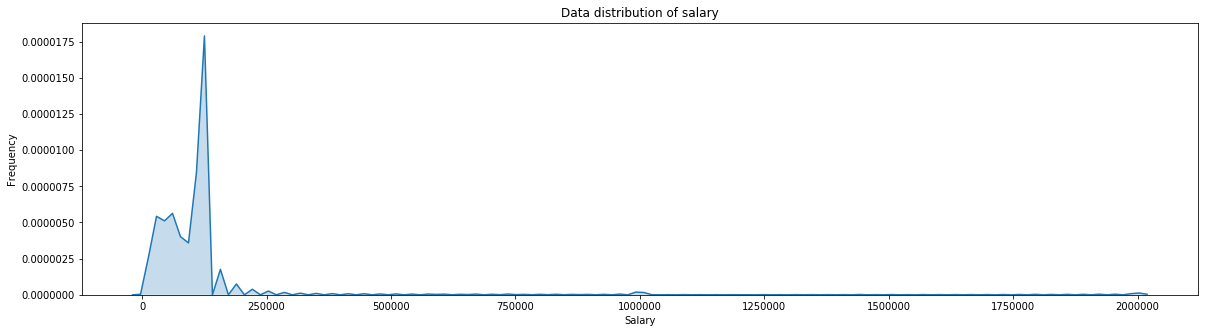

In [9]:
# Plot salary distribution
plt.figure(figsize=(20,5))
kde = sns.kdeplot(salaries, shade=True)
kde.set(title='Data distribution of salary', 
        xlabel='Salary', ylabel='Frequency');

The distribution of salary appears the be very skewed. To reduce the skew, log transformation can be applied on the salaries. But before we can do this, the salaries with value zero needs to be filtered out (logarithm of zero is impossible).

In [10]:
salaries = np.log(salaries[salaries != 0])

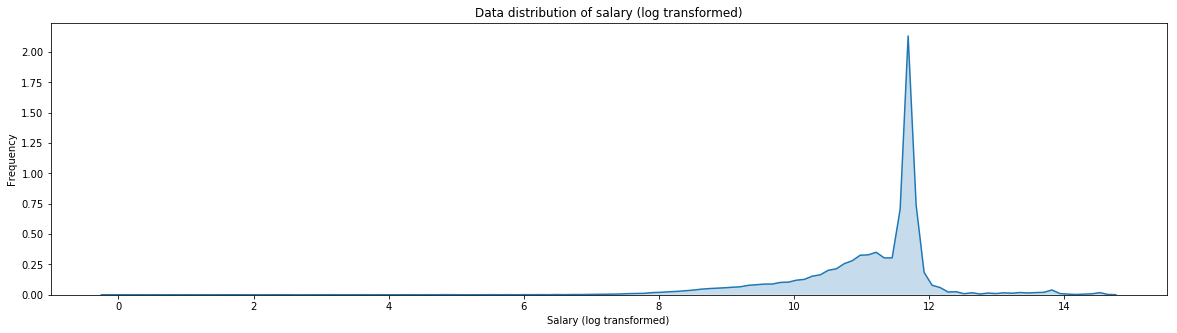

In [11]:
# Plot salary distribution (log transformed)
plt.figure(figsize=(20,5))
kde = sns.kdeplot(salaries, shade=True)
kde.set(title='Data distribution of salary (log transformed)', 
        xlabel='Salary (log transformed)', 
        ylabel='Frequency');

The data distribution has now more the appearance of a gaussian distribution (bell curve shape). Although, the data is still skewed due to the outliers. If the many outliers will cause the classification model to perform badly, the outliers will be removed. This can be done, for example, by pruning the data by $x$ times the standard deviation of the salaries.

### 3.4. Scatter Job Satisfaction and Career Satisfaction

In [12]:
satisfaction = so_survey[['JobSatisfaction', 'CareerSatisfaction']]

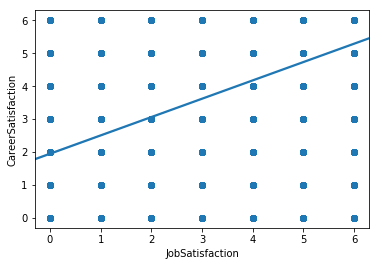

In [16]:
reg = sns.regplot(x='JobSatisfaction', y='CareerSatisfaction', data=satisfaction)

The scatter plot looks a bit odd because of the classifications in the column JobSatisfaction and CareerSatisfaction. But, the regression line shows that there is a positive correlation between Job Satisfaction and Career Satisfaction.

### 3.5. Scatter Job Satisfaction and Converted Salary

In [19]:
sat_sal = so_survey[['JobSatisfaction', 'ConvertedSalary']]
sat_sal['ConvertedSalary'] = np.log(sat_sal['ConvertedSalary'][sat_sal['ConvertedSalary'] != 0])

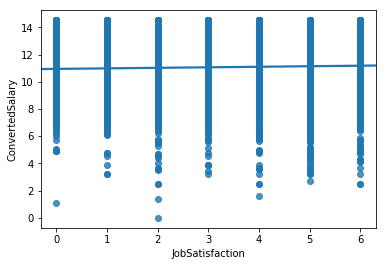

In [20]:
reg = sns.regplot(x='JobSatisfaction', y='ConvertedSalary', data=sat_sal)

This scatter plot looks alos bit odd because of the classifications in the column JobSatisfaction. The regression line shows that there is a small positive correlation between Job Satisfaction and Salary.

## 4. Research strategy
The research will be conducted by using following steps:
1. Loosely optimize the hyperparameters of a classifier that will be used in the feature selection part. This prevents selecting features with e.g. an overfitted/underfit model.
2. Selecting features with the finetuned classifier. (feature selection is necessary since training classifiers with 622 features and more than 69000 rows is extremely time consuming) 
3. Use the selected features to train and optimize different Machine Learning algorithms.
4. Compare the performance of the different models.

## 5. Setup training and testing sets

In [12]:
# Import necessary sklearn libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [13]:
# Set target (y) 
target = 'JobSatisfaction'
y = so_survey[target]

In [14]:
# Set features (X)
features = [x for x in so_survey.columns if x != target]
X = so_survey[features]

### 5.1. Perform feature scaling
The column 'ConvertedSalary' will be log tranformed to reduce skewness. Also, a min max scaler will be used to scale the features to values between 0 and 1, resulting in all features having values within the same range. This has some benefits:
+ All features have the same 'weight'. This will help algorithms like SVM (with Gaussian kernel) and K-means to perform better.
+ Speeds up Gradient Descent while training.
+ Improves insight in coefficients. If all features have the same 'weight', the resulting coefficients will describe the influence of feature on the target better. This is useful for feature selection.

In [15]:
# Taking the logarithm of 0 is impossible.
# For this reason the values of 0 will be replaced by 0.1.
X['ConvertedSalary'].loc[(X['ConvertedSalary'] == 0)] = 0.1

# Perform log transformation on the values in the column 'ConvertedSalary'
X['ConvertedSalary'] = np.log(X['ConvertedSalary'])

In [16]:
# Perform feature scaling with min max scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

### 5.2. Get training and testing sets
The features and target values will be split into training and testing sets.
The training set will contain 75% of the dataset (randomly selected rows).
The testing set will therefore contain 25% of the dataset.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

## 6. Loosely optimize estimator
The Random Forest classifier will be used as an estimator for the feature selection step. This has the following benefits:
+ Popular feature selection algorithms like RFE or RFECV are recursively training a classifier. This will take a lot of time. Decision Trees are faster than classifiers such as Neural Networks or Support Vector Machines. 
+ By using a Random Forest the main drawback of Decision Trees (overfitting the training set) will be (partly) solved.
+ It isn't known if the classes are linear separatable. A Random Forest is both a linear and a non-linear classifier.
<br><br>The RandomizedSearch method will be used in contrast to GridSearch, because RandomizedSearch doesn't compute all possible computations (hence 'loosely') and is therefore computationally less expensive.

In [18]:
# Import Random Forest classifier and RandomizedSearchCV algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [19]:
# Create the random grid with hyperparameter ranges
random_grid = { 'n_estimators': np.arange(50, 250, 50),
                'max_depth': [5],
                'min_samples_split': np.arange(50, 105, 5),
                'min_samples_leaf': np.arange(20, 55, 5) }
# Print grid
[print('%s: %s' % x) for x in random_grid.items()];

n_estimators: [ 50 100 150 200]
max_depth: [5]
min_samples_split: [ 50  55  60  65  70  75  80  85  90  95 100]
min_samples_leaf: [20 25 30 35 40 45 50]


In [20]:
# Train default Random Forest classifier for comparison
default_score = np.sum(cross_val_score(RandomForestClassifier(random_state=21), X, y, cv=5)) / 5

# Print default cross-validated accuracy
print('Mean cross-validated accuracy of the default estimator: %0.3f' % (default_score))

Mean cross-validated accuracy of the default estimator: 0.794


In [21]:
# Random Search of optimal set of hyperparameters using 3 fold cross validation and 25 different combinations. 
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=21), 
                                   param_distributions=random_grid, 
                                   n_iter=25, 
                                   cv=3, 
                                   verbose=1, 
                                   random_state=21, 
                                   n_jobs=-1)

In [22]:
# Fit Random Search on the training set
random_search = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.4min finished


In [23]:
# Show best parameters
random_search.best_params_

{'n_estimators': 50,
 'min_samples_split': 55,
 'min_samples_leaf': 20,
 'max_depth': 5}

In [24]:
# Print best cross-validated accuracy
print('Mean cross-validated accuracy of the best estimator: %0.3f' % (random_search.best_score_))

# Print improvements relative to Random Forest classfier with default hyperparameters
improvement = random_search.best_score_ - default_score
print('Improvement relative to default mean cross-validated accuracy: : %0.3f' % (improvement))

Mean cross-validated accuracy of the best estimator: 0.753
Improvement relative to default mean cross-validated accuracy: : -0.041


## 7. Feature selection
The datasets contains 622 features and about 69000 rows. Training with such an amount of features can take a very long time for algorithms like SVM (expontential time complexity). The training process becomes much faster by pruning redundant features.

### 7.1. RFECV (Recursive Feature Elimination with Cross-Validation)
Recursive Feature Elimination is a method that uses an estimator (in this case a classifier) that assigns weights to features (coefficients). The goal is to recursively select features by considering smaller and smaller sets of features. The least important features are pruned from the training and testing set. Cross Validation is used to make a selection of the best number of features.<br>
The estimator that will be used is the Random Forest classifier.

In [25]:
# Import RFECV algorithm
from sklearn.feature_selection import RFECV

In [26]:
# Instantiate the RFECV algorithm with the loosely optimized Random Forest classifier
f_selector = RFECV(estimator=random_search.best_estimator_ ,
                   step=1,
                   cv=3,
                   n_jobs=-1)

In [ ]:
# Fit the RFECV on the training set
f_selector = f_selector.fit(X_train, y_train)

In [ ]:
# Plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation accuracy')
plt.plot(range(1, len(f_selector.grid_scores_) + 1), f_selector.grid_scores_)
plt.show()

In [ ]:
# Show best number of features
print('Optimal number of features: %i' % (f_selector.n_features_))

In [ ]:
# Create a dataframe that shows the ranking of features
def create_ranking_df(ranking_list, columns):
    ranking = {}
    for i in range(len(ranking_list)):
        rank = ranking_list[i]
        col = columns[i]
        if rank in ranking:
            ranking[rank].append(col)
        else:
            ranking[rank] = [col]
    ranking = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in ranking.items()]))
    return ranking.reindex(sorted(ranking.columns), axis=1)

In [ ]:
# Show ranking
ranking = create_ranking_df(f_selector.ranking_, X.columns)
ranking

### 7.2. Prune redundant featues
The selected features will be used to create the new training set and test set.
CareerSatisfaction and ConvertedSalary will be added to the selection if they are not selected. This is because the two values are needed to promote or reject the defined hypothesis.

In [ ]:
# Get indeces of best selection of features
best_features = [i for i, rank in enumerate(f_selector.ranking_) if rank == 1]

In [ ]:
# Get indexes of 'CareerSatisfaction' and 'ConvertedSalary'
satisfaction = [i for i, col in enumerate(X.columns) if col == 'CareerSatisfaction'][0]
salary= [i for i, col in enumerate(X.columns) if col == 'ConvertedSalary'][0]

# If index is not yet in selection: add it to selection
if satisfaction not in best_features: best_features.append(satisfaction)
if salary not in best_features: best_features.append(salary)

In [ ]:
feature_labels = X.columns[best_features]
X_train_best = X_train[:,best_features]
X_test_best = X_test[:,best_features]

## 8. Train and optimize different algorithms
In this section the following Machine Learning algorithms/methods will be optimized and trained to predict job satisfaction:
+ Random Forest (Classifier)
+ Support Vector Machine
+ Naive Bayes
+ Random Forest (Regressor)
+ K-means
+ Ensemble Learning (combining above algorithms)

In [ ]:
# Import GridSearchCV algorithm to select best combination of hyperparameters
from sklearn.model_selection import GridSearchCV

# Import leaning_curve and validation_curve to evaluate trained models
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
# Define a function for plotting learning curves:
# Learning curves show the learning rate of the training and 
# cross-validation set over training examples (m).
def plot_learning_curve(estimator, title, X, y, scoring='accuracy'):    
    # Fit to get parameters for the learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator,
        X, y, cv=3, train_sizes=np.linspace(.1, 1.0, 5), scoring=scoring, n_jobs=-1)
    
    # Get mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # Get mean and standard deviation for cross-validation scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Setup chart
    plt.figure()
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Score (' + scoring + ')')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='b')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='b',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label='Cross-validation score')
    plt.legend(loc='best')

    return plt

In [ ]:
# Define a function for plotting validation curves:
# Validation curves show the learning rate of the training and 
# cross-validation set over a range of values of a defined hyperparameter.
def plot_validation_curve(estimator, title, X, y, param_range, param_name, scoring='accuracy'):
    # Fit to get parameters for the validation curve
    train_scores, test_scores = validation_curve(estimator,
        X, y, cv=3, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=-1)
    
    # Get mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Get mean and standard deviation for cross-validation scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Setup chart
    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Score (' + scoring + ')')
    plt.grid()
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='g', lw=2)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color='r', lw=2)
    plt.plot(param_range, train_scores_mean, 'o-', color='g',
         label='Training score')
    plt.plot(param_range, test_scores_mean, 'o-', color='r',
             label='Cross-validation score')
    plt.legend(loc='best')
    
    return plt

In [ ]:
def clf_metrics(y_test, y_pred, show=True):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred))
    precision = precision_score(y_test, y_pred, average='macro', labels=np.unique(y_pred))
    recall = recall_score(y_test, y_pred, average='macro', labels=np.unique(y_pred))
    if show:
        print('Accuracy on test set: %0.3f' % (accuracy))
        print('F1-score on test set: %0.3f' % (f1))
        print('Precision on test set: %0.3f' % (precision))
        print('Recall on test set: %0.3f' % (recall))
    return accuracy, f1, precision, recall

### 8.1. Random Forest (Classifier)
*Inherently multiclass*<br><br>
The Random Forest classifier is used before when selecting features. This time the Random Forest classifier will be used to predict the job satisfaction using the selected features.
First, the default Random Forest classifier will trained on the training set and evaluated.
After the evaluation, a second Random Forest will be used to select the optimal hyperparameters.
The Random Forest classifier containing the optimal hyperparamaters will be evaluated on high variance (overfitting), high bias (underfitting) and performance based on accuracy.<br>
The following hyperparameters will be optimized:
+ n_estimators: The number of trees in the forest.
+ max_depth: The maximum depth of the tree.
+ min_samples_split: The minimum number of samples required to split an internal node.
+ min_samples_leaf: The minimum number of samples required to be at a leaf node.

#### 8.1.1. Training the default Random Forest classifier

In [ ]:
# Train default Random Forest classifier for comparison
rf_clf_default = RandomForestClassifier(random_state=21)
rf_clf_default_score = np.sum(cross_val_score(rf_clf_default, X_train_best, y_train, cv=5)) / 5

# Print default cross-validated accuracy
print('Mean cross-validated accuracy of the Random Forest classifier with default hyperparameters: %0.3f' % (rf_clf_default_score))

In [ ]:
# Show default classification metrics
rf_clf_default.fit(X_train_best, y_train)
rf_clf_default_metrics = clf_metrics(y_test, rf_clf_default.predict(X_test_best));

In [ ]:
# Plot learning curve
plot_learning_curve(RandomForestClassifier(random_state=21),
                    'Learning Curves of RF (default)',
                    X_train_best, y_train)
plt.show()

A high variance problem (overfitted) will occur when using the default Random Forest classifier. The training set starts of with high accuracy (as expected) but the accuracy doesn't decline much as the number of training examples increases. In contrast, the cross-validation accuracy starts off with low accuracy and increases with very small amounts as the number of training examples increases. This high variance problem can be solved by evaluating different hyperparameters of the Random Forest classifier and using the results to optimize the classifier.

#### 8.1.2. Evaluate hyperparameters
Show the validation curve of different hyperparamethers of the Random Forest classifiers (for both the training and cross-validation set). The results will be used to select a range of hyperparameter to perform Grid Search on, which will optimize the hyperparameters more efficiently.

##### n_estimators

In [ ]:
# Show validation curve for different values of hyperparameter 'n_estimators'
n_estimators = np.arange(5, 505, 50)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'RF accuracy for different values of n_estimator', 
                      X_train_best, 
                      y_train, 
                      n_estimators, 
                      'n_estimators')
plt.show()

Increasing the hyperparameter 'n_estimators' seems to increase the accuracy of the training set between the values 0 and 100, which will add to the high variance problem. Also, increasing 'min_samples_split' doesn't seems to increase the accuracy of the cross-validation set very much. Becuase increasing 'n_estimators' doesn't seem te be necessary, the range between 5 and 100 will be used when performing GridSearch. 

##### max_depth

In [ ]:
# Show validation curve for different values of hyperparameter 'max_depth'
max_depth = np.arange(5, 75, 5)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'RF accuracy for different values of max_depth', 
                      X_train_best, 
                      y_train, 
                      max_depth, 
                      'max_depth')
plt.show()

Increasing the hyperparameter 'max_depth' seems to increase the accuracy of the training set between the values 0 and 30, which will add to the high variance problem. Also, increasing 'min_samples_split' does seem to decrease the accuracy of the cross-validation set between the values 0 and 30. Because an increase in 'max_depth' does almost instantly increase the high variance problem and decrease the accuracy, only the value 5 will be used when performing GridSearch.

##### min_samples_split

In [ ]:
# Show validation curve for different values of hyperparameter 'min_samples_split'
min_samples_split = np.arange(5, 755, 30)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'RF accuracy for different values of min_samples_split', 
                      X_train_best, 
                      y_train, 
                      min_samples_split, 
                      'min_samples_split')
plt.show()

Increasing the hyperparameter 'min_samples_split' seems to lower the accuracy of the training set, which will reduce the high variance problem. Increasing 'min_samples_split' also seems to increase the accuracy of the cross-validation set, with a plateau between de values 300 and 500. The range between 300 and 500 will therefore be used when performing GridSearch.

##### min_samples_leaf

In [ ]:
# Show validation curve for different values of hyperparameter 'min_samples_leaf'
min_samples_leaf = np.arange(5, 210, 10)
plot_validation_curve(RandomForestClassifier(random_state=21), 
                      'RF accuracy for different values of min_samples_leaf', 
                      X_train_best, 
                      y_train, 
                      min_samples_leaf, 
                      'min_samples_leaf')
plt.show()

Increasing the hyperparameter 'min_samples_leaf' seems to lower the accuracy of the training set, which will reduce the high variance problem. Increasing 'min_samples_leaf' also seems to increase the accuracy of the cross-validation set, with a plateau between de values 60 and 150. The range between 60 and 150 will therefore be used when performing GridSearch.

#### 8.1.3. Optimize Random Forest classifier

In [ ]:
# Create the grid
rf_grid = { 'n_estimators': np.arange(5, 115, 10),
            'max_depth': [5],
            'min_samples_split': np.arange(300, 520, 20),
            'min_samples_leaf': np.arange(60, 165, 15) }
# Print grid
[print('%s: %s' % x) for x in rf_grid.items()];

In [ ]:
rf_clf = RandomForestClassifier(random_state=21)
rf_grid_search = GridSearchCV(estimator=rf_clf,
                              param_grid=rf_grid,
                              cv=5,
                              verbose=2,
                              n_jobs=-1)
# Fit the random search model
rf_grid_search = rf_grid_search.fit(X_train_best, y_train)

In [ ]:
# Show best parameters
rf_grid_search.best_params_

In [ ]:
# Print best cross-validated accuracy
print('Mean cross-validated accuracy of the Random Forest classifier with optimized hyperparameters: %0.3f' % (rf_grid_search.best_score_))

# Print improvements relative to Random Forest classfier with default hyperparameters
improvement = rf_grid_search.best_score_ - rf_clf_default_score
print('Improvement relative to default mean cross-validated accuracy: : %0.3f' % (improvement))

In [ ]:
# Instantiate Random Forest classifier using the best hyperparameters
rf_clf = rf_grid_search.best_estimator_ 

In [ ]:
# Plot learning curve
plot_learning_curve(rf_clf, 'Learning Curves of RF (optimized)', X_train_best, y_train)
plt.show()

Rule of thumb is: The larger the gap between the cross-validation set and the training the set the higher the variance (overfit). After finetuning the hyperparamters of the Random Forest classifier according to the training data, the cross-validation accuracy and the training set accuracy converges. This concludes that the problem of overfitting has been solved.

#### 8.1.4. Metrics

In [ ]:
rf_clf_metrics = clf_metrics(y_test, rf_clf.predict(X_test_best))

In [ ]:
# Show improvements relative to the default classification metrics
print('Accuracy improvement of: %0.3f' % (rf_clf_metrics[0] - rf_clf_default_metrics[0]))
print('F1-score improvement of: %0.3f' % (rf_clf_metrics[1] - rf_clf_default_metrics[1]))
print('Precision improvement of: %0.3f' % (rf_clf_metrics[2] - rf_clf_default_metrics[2]))
print('Recall improvement of: %0.3f' % (rf_clf_metrics[3] - rf_clf_default_metrics[3]))

### 8.2. Support Vector Machine
*Multiclass as One-Vs-One*<br><br>
The Support Vector Machine classifier will be used to predict the job satisfaction using the selected features.
First, the default Support Vector Machine classifier will trained on the training set and evaluated.
After the evaluation, a second Support Vector Machine classifier will be used to select the optimal hyperparameters.
The Support Vector Machine classifier containing the optimal hyperparamaters will be evaluated on high variance (overfitting), high bias (underfitting) and perfomance based on accuracy.<br>
The following hyperparameters will be optimized:
+ C: Penalty parameter C of the error term.
+ gamma: Kernel coefficient.
+ kernel: The kernel type to be used in the algorithm ('linear', 'rbf').

In [ ]:
# Import Support Vector Machine module
from sklearn.svm import SVC

#### 8.2.1. Training the default Support Vector Machine classifier

In [ ]:
# Train default Support Vector Machine classifier for comparison
svm_clf_default = SVC(random_state=21)
svm_clf_default_score = np.sum(cross_val_score(svm_clf_default, X_train_best, y_train, cv=5, n_jobs=-1)) / 5

# Print default cross-validated accuracy
print('Mean cross-validated accuracy of the Support Vector Machine classifier with default hyperparameters: %0.3f' % (svm_clf_default_score))

In [ ]:
# Show default classification metrics
svm_clf_default.fit(X_train_best, y_train)
svm_clf_default_metrics = clf_metrics(y_test, svm_clf_default.predict(X_test_best))

An initial comparison will be made between a Support Vector Machine using the Linear kernel and one using the Gaussian kerntel. The results of this comparison can give better insight into the nature of the data. Is it linearly seperatable or not? If one kernel outperforms the other, the underperforming kernel will be removed from further evaluation.

In [ ]:
# Plot learning curve using the gaussian (rbf) kernel
plot_learning_curve(SVC(kernel='rbf', random_state=21),
                    'Learning Curves of SVM with Guassian kernel (default)',
                    X_train_best, y_train)
plt.show()

The default Support Vector Machine classifier with the Gaussian kernel doesn't seem to overfit or underfit the data. The gap between the cross-validations scores and the traing scores are almost non-non-existent. The goal therefore is to only improve the current accuracy by optimizing the hyperparameters.

In [ ]:
plot_learning_curve(SVC(kernel='linear', random_state=21),
                    'Learning Curves of SVM with Linear kernel (default)', X_train_best, y_train)
plt.show()

The default Support Vector Machine classifier with the Linear kernel performs way than the Support Vector Machine classifier with the Gaussian kernel. This concludes that the data is more non-linearly than it is linearly seperatable. For this reason the Linear kernel won't be used for further evaluation.

#### 8.2.2. Evaluate hyperparameters

Show the validation curve of different hyperparamethers of the Support Vector Machine classifiers (for both the training and cross-validation set). The results will be used to select a range of hyperparameter to perform Grid Search on, which will optimize the hyperparameters more efficiently.

##### C

In [ ]:
# Show validation curve for different values of hyperparameter 'C'
C = np.logspace(-1, 3, 5)
plot_validation_curve(SVC(kernel='rbf', random_state=21),
                      'SVM accuracy for different values of C with Gaussian kernel', 
                      X_train_best, 
                      y_train, 
                      C, 
                      'C')
plt.show()

Increasing the hyperparameter 'C' seems to increase the accuracy of the training set between the values 1 and 10000. It also looks like the line is still increasing after the value of 10000. Although increasing C seems to increase the accuracy, only the value of 1 will be used. The values 10 and higher result in a very long processing time, because the model tries to fit every example with a small margin. The value of 1 will still yield a good accuracy and it performs reasonably fast.

##### gamma

In [ ]:
# Show validation curve for different values of hyperparameter 'gamma'
gamma = np.logspace(-1, 3, 5)
plot_validation_curve(SVC(kernel='rbf', random_state=21),
                      'SVM accuracy for different values of gamma with Gaussian kernel', 
                      X_train_best, 
                      y_train, 
                      gamma, 
                      'gamma')
plt.show()

The cross-validation accuracy raises till a 'gamma' value of 100. After this value the cross-validation set score decreases slowly. Also, the training set score keeps raising after the 'gamma' value of 10. This indicates that overfitting can cause an issue if a value is picked above the value of 10 or 100. Only the value of 10 will be chosen because a bigger value will take alot of time to process and this value still yield a reasonable good accuracy.

#### 8.2.3. Optimize Support Vector Machine classifier

Grid Search will not be necessary for this optimization part. The evaluation part gave a good indication of which values to use as the hyperparameters.

In [ ]:
# Create the grid
svm_grid = { 'C': 1,
             'gamma': 10,
             'kernel': 'rbf' }
# Print grid
[print('%s: %s' % x) for x in svm_grid.items()];

In [ ]:
# Initialize and fit Support Vector Machine with selected hyperparameter values
svm_clf = SVC(random_state=21,
              C=svm_grid['C'],
              gamma=svm_grid['gamma'],
              kernel=svm_grid['kernel'])
svm_clf = svm_clf.fit(X_train_best, y_train)

In [ ]:
# Print cross-validated accuracy
svm_clf_score = np.sum(cross_val_score(svm_clf, X_train_best, y_train, cv=5)) / 5
print('Mean cross-validated score of the best estimator: %0.3f' % (svm_clf_score))

In [ ]:
# Plot learning curve
plot_learning_curve(svm_clf, 'Learning Curves of SVM (optimized)', X_train_best, y_train)
plt.show()

The model has become slightly more overfitted because the gap between the training accuracy and the cross-validation accuracy is slightly bigger. This gap is still small enough to not pose a overfitting problem. All in all, it converges nicely.

#### 8.2.4. Metrics

In [ ]:
svm_clf_metrics = clf_metrics(y_test, svm_clf.predict(X_test_best))

In [ ]:
# Show improvements relative to the default classification metrics
print('Accuracy improvement of: %0.3f' % (svm_clf_metrics[0] - svm_clf_default_metrics[0]))
print('F1-score improvement of: %0.3f' % (svm_clf_metrics[1] - svm_clf_default_metrics[1]))
print('Precision improvement of: %0.3f' % (svm_clf_metrics[2] - svm_clf_default_metrics[2]))
print('Recall improvement of: %0.3f' % (svm_clf_metrics[3] - svm_clf_default_metrics[3]))

### 8.3. Naive Bayes
*Inherently multiclass*<br><br>
The Naive Bayes classifier will be used to predict the job satisfaction using the selected features.
First, the Gaussian Naive Bayes classifier will trained on the training set and evaluated.
After the evaluation, the Multinomial Naive Bayes classifier will be trained on the training set and evaluated.
Both versions of the Naive Bayes classifier will be compared. The best performing classifier will be chosen. There will be no optimization part because Naive Bayes has no hyperparameters to optimize.

In [ ]:
# Import Naive Bayes modules
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

#### 8.3.1. Training the Gaussian Naive Bayes classifier

In [ ]:
# Train Gaussian Naive Bayes classifier for comparison
gnb_clf = GaussianNB()
gnb_clf_score = np.sum(cross_val_score(gnb_clf, X_train_best, y_train, cv=5)) / 5

# Print cross-validated accuracy of Gaussian Naive Bayes classifier
print('Mean cross-validated accuracy of the Gaussian Naive Bayes classifier: %0.3f' % (gnb_clf_score))

In [ ]:
# Show classification metrics
gnb_clf.fit(X_train_best, y_train)
gnb_clf_metrics = clf_metrics(y_test, gnb_clf.predict(X_test_best))

In [ ]:
# Plot learning curve
plot_learning_curve(GaussianNB(), 'Learning Curves of Gaussian Naive Bayes', X_train_best, y_train)
plt.show()

Gaussian Naive Bayes permorms reasonably good despite its simplicity. The cross-validation accuracy and training accuracy have almost no gap between eachother, which concludes that there is no overfit. But, the accuracy of both sets decline while the traning examples grow. This could indicate a small underfit.

#### 8.3.2. Training the Multinomial Naive Bayes classifier

In [ ]:
# Train Multinomial Naive Bayes classifier for comparison
mnb_clf = MultinomialNB()
mnb_clf_score = np.sum(cross_val_score(mnb_clf, X_train_best, y_train, cv=5)) / 5

# Print cross-validated accuracy of Multinomial Naive Bayes classifier
print('Mean cross-validated score of the Multinomial Naive Bayes: %0.3f' % (mnb_clf_score))

In [ ]:
# Show classification metrics
mnb_clf.fit(X_train_best, y_train)
mnb_clf_metrics = clf_metrics(y_test, mnb_clf.predict(X_test_best))

In [ ]:
# Plot learning curve
plot_learning_curve(MultinomialNB(), 'Learning Curves of Multinomial Naive Bayes', X_train_best, y_train)
plt.show()

Multinomial Naive Bayes permorms worse than the Gaussian Naive Bayes. The cross-validation accuracy and training accuracy have almost no gap between eachother, which concludes that there is no overfit. There is alsno no sign of rapid accuracy decline, which concludes there is also no underfit.

#### 8.3.3. Optimize Naive Bayes classifier
No hyperparameters to optimize.

In [ ]:
nb_clf = gnb_clf

#### 8.3.4. Metrics

In [ ]:
nb_clf_metrics = clf_metrics(y_test, nb_clf.predict(X_test_best))

### 8.4. Random Forest (Regressor)
*Regressor*<br><br>
The Random Forest regressor will be used to predict the job satisfaction using the selected features.
First, the default Random Forest regressor will trained on the training set and evaluated.
After the evaluation, a second Random Forest regressor will be used to select the optimal hyperparameters.
The Random Forest regressor containing the optimal hyperparamaters will be evaluated on high variance (overfitting), high bias (underfitting) and performance based on the R2 score.<br>
The following hyperparameters will be optimized:
+ n_estimators: The number of trees in the forest.
+ max_depth: The maximum depth of the tree.
+ min_samples_split: The minimum number of samples required to split an internal node.
+ min_samples_leaf: The minimum number of samples required to be at a leaf node.
<br><br>
Two sets of metrics will be used to measure performance. The first set contains the R2 score, Mean Absolute Error and Mean Squared Error. The second set contains the same metrics as the classifiers (accuracy, f1, recall, precision). The accuracy will be measure by rounding the predicted values of the regressor to represent classes.

In [ ]:
# Import Random Forest Regressor module
from sklearn.ensemble import RandomForestRegressor

# Import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
def reg_metrics(y_test, y_pred, show=True):
    r2 = r2_score(y_test, y_pred)
    mean_abs_err = mean_absolute_error(y_test, y_pred)
    mean_sqr_err = mean_squared_error(y_test, y_pred)
    if show:
        print('R2 on test set: %0.3f' % (r2))
        print('Mean Absolute Error on test set: %0.3f' % (mean_abs_err))
        print('Mean Squared Error on test set: %0.3f' % (mean_sqr_err))
    return r2, mean_abs_err, mean_sqr_err

#### 8.4.1. Training the default Random Forest regressor

In [ ]:
# Train default Random Forest regressor for comparison
rf_reg_default = RandomForestRegressor(random_state=21)
rf_reg_default_score = np.sum(cross_val_score(rf_reg_default, X_train_best, y_train, cv=5, scoring='r2')) / 5

# Print default cross-validated R2 score
print('Mean cross-validated R2 score of the Random Forest regressor with default hyperparameters: %0.3f' % (rf_reg_default_score))

In [ ]:
# Show default cross-validated regression metrics
rf_reg_default.fit(X_train_best, y_train)
rf_reg_default_reg_metrics = reg_metrics(y_test, rf_reg_default.predict(X_test_best))

In [ ]:
# Show default cross-validated classification metrics
y_pred = np.round(rf_reg_default.predict(X_test_best))
rf_reg_default_metrics = clf_metrics(y_test, y_pred)

In [ ]:
# Plot learning curve
plot_learning_curve(RandomForestRegressor(random_state=21), 'Learning Curves of RF regressor (default)',
                    X_train_best, y_train,
                    scoring='r2')
plt.show()

A high variance problem (overfitted) will occur when using the default Random Forest regressor. The training set starts of with high accuracy (as expected) but the accuracy doesn't decline much as the number of training examples increases. In contrast, the cross-validation accuracy starts off with low accuracy and increases with very small amounts as the number of training examples increases. This high variance problem can be solved by evaluating different hyperparameters of the Random Forest regressor and using the results to optimize the regressor.

#### 8.4.2. Evaluate hyperparameters
Show the validation curve of different hyperparamethers of the Random Forest regressor (for both training and cross-validation set). The results will be used to select a range of hyperparameter to perform GridSearch on, which will fine tune the hyperparameters more efficiently.

##### n_estimators

In [ ]:
# Show validation curve for different values of hyperparameter 'n_estimators'
n_estimators = np.arange(5, 505, 50)
plot_validation_curve(RandomForestRegressor(random_state=21), 
                      'RF accuracy for different values of n_estimator', 
                      X_train_best, 
                      y_train, 
                      n_estimators, 
                      'n_estimators',
                      scoring='r2')
plt.show()

Increasing the hyperparameter 'n_estimators' seems to increase the accuracy of the training set between the values 0 and 100, which will add to the high variance problem. Also, increasing 'min_samples_split' doesn't seems to increase the accuracy of the cross-validation set very much. Becuase increasing 'n_estimators' doesn't seem te be necessary, the range between 5 and 100 will be used when performing GridSearch. 

##### max_depth

In [ ]:
# Show validation curve for different values of hyperparameter 'max_depth'
max_depth = np.arange(5, 75, 5)
plot_validation_curve(RandomForestRegressor(random_state=21), 
                      'RF accuracy for different values of max_depth', 
                      X_train_best, 
                      y_train, 
                      max_depth, 
                      'max_depth',
                      scoring='r2')
plt.show()

Increasing the hyperparameter 'max_depth' seems to increase the accuracy of the training set between the values 0 and 30, which will add to the high variance problem. Also, increasing 'min_samples_split' does seem to decrease the accuracy of the cross-validation set between the values 0 and 30. Because an increase in 'max_depth' does almost instantly increase the high variance problem and decrease the accuracy, only the value 5 will be used when performing GridSearch.

##### min_samples_split

In [ ]:
# Show validation curve for different values of hyperparameter 'min_samples_split'
min_samples_split = np.arange(5, 850, 30)
plot_validation_curve(RandomForestRegressor(random_state=21), 
                      'RF accuracy for different values of min_samples_split', 
                      X_train_best, 
                      y_train, 
                      min_samples_split, 
                      'min_samples_split',
                      scoring='r2')
plt.show()

Increasing the hyperparameter 'min_samples_split' seems to lower the accuracy of the training set, which will reduce the high variance problem. Increasing 'min_samples_split' also seems to increase the accuracy of the cross-validation set, with a plateau between de values 500 and 850. The range between 500 and 850 will therefore be used when performing GridSearch.

##### min_samples_leaf

In [ ]:
# Show validation curve for different values of hyperparameter 'min_samples_leaf'
min_samples_leaf = np.arange(5, 250, 10)
plot_validation_curve(RandomForestRegressor(random_state=21), 
                      'RF accuracy for different values of min_samples_leaf', 
                      X_train_best, 
                      y_train, 
                      min_samples_leaf, 
                      'min_samples_leaf',
                      scoring='r2')
plt.show()

Increasing the hyperparameter 'min_samples_leaf' seems to lower the accuracy of the training set, which will reduce the high variance problem. Increasing 'min_samples_leaf' also seems to increase the accuracy of the cross-validation set, with a plateau between de values 100 and 250. The range between 100 and 250 will therefore be used when performing GridSearch.

#### 8.4.3. Optimize Random Forest regressor

In [ ]:
# Create the grid
rf_reg_grid = { 'n_estimators': np.arange(5, 115, 10),
                'max_depth': [5],
                'min_samples_split': np.arange(400, 850, 50),
                'min_samples_leaf': np.arange(100, 275, 25) }
# Print grid
[print('%s: %s' % x) for x in rf_reg_grid.items()];

In [ ]:
rf_reg = RandomForestRegressor(random_state=21)
rf_reg_grid_search = GridSearchCV(estimator=rf_reg,
                                  param_grid=rf_reg_grid,
                                  cv=5,
                                  verbose=2,
                                  n_jobs=-1,
                                  scoring='r2')
# Fit the random search model
rf_reg_grid_search = rf_reg_grid_search.fit(X_train_best, y_train)

In [ ]:
# Show best parameters
rf_reg_grid_search.best_params_

In [ ]:
# Print best cross-validated score
print('R2 score of the best estimator: %0.3f' % (rf_reg_grid_search.best_score_))
print('Improvement relative to default R2 score: : %0.3f' % (rf_reg_grid_search.best_score_ - rf_reg_default_score))

# Show best parameters
best_rf_reg_params = rf_reg_grid_search.best_params_
best_rf_reg_params

In [ ]:
# Instantiate Random Forest regressor using the best hyperparameters
rf_reg = rf_reg_grid_search.best_estimator_ 

In [ ]:
plot_learning_curve(rf_reg, 'Learning Curves of RF regressor (optimized)',
                    X_train_best, y_train,
                    scoring='r2')
plt.show()

After finetuning the hyperparamters of the Random Forest regressor according to the training data, the cross-validation accuracy and the training set accuracy converges. This concludes that the problem of overfitting has been solved.

#### 8.4.4. Metrics

In [ ]:
rf_reg_reg_metrics = reg_metrics(y_test, rf_reg.predict(X_test_best));

In [ ]:
# Show improvements relative to the default cross-validated regression metrics
print('R2 score improvement of: %0.3f' % (rf_reg_reg_metrics[0] - rf_reg_default_reg_metrics[0]))
print('Mean Absolute Error improvement of: %0.3f' % (rf_reg_reg_metrics[1] - rf_reg_default_reg_metrics[1]))
print('Mean Squared Error improvement of: %0.3f' % (rf_reg_reg_metrics[2] - rf_reg_default_reg_metrics[2]))

In [ ]:
y_pred = np.round(rf_reg.predict(X_test_best))
rf_reg_metrics = clf_metrics(y_test, y_pred)

In [ ]:
# Show improvements relative to the default cross-validated classification metrics
print('Accuracy improvement of: %0.3f' % (rf_reg_metrics[0] - rf_reg_default_metrics[0]))
print('F1-score improvement of: %0.3f' % (rf_reg_metrics[1] - rf_reg_default_metrics[1]))
print('Precision improvement of: %0.3f' % (rf_reg_metrics[2] - rf_reg_default_metrics[2]))
print('Recall improvement of: %0.3f' % (rf_reg_metrics[3] - rf_reg_default_metrics[3]))

### 8.5. K-means
*Clustering*<br><br>
K-means will be used to predict the job satisfaction using the selected features.
This unsupervised clustering algorithm will search for 7 clusters (target feature has 7 labels). The outputted labels will be permuted. The permutation with the highest performance (accurayc) will be be choses as prediction.<br>
K-means has no hyperparameters that could be optimzed. K-means can't also be plotted with a Learning Curve because of it's unsupervised nature.

In [ ]:
# Import K-means module
from sklearn.cluster import KMeans

# Import metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

from scipy.stats import mode

In [ ]:
def clt_metrics(y_test, y_pred, show=True):
    accuracy = accuracy_score(y_test, y_pred)
    homogeneity = homogeneity_score(y_test, y_pred)
    completeness = completeness_score(y_test, y_pred)
    v_measure = v_measure_score(y_test, y_pred)
    if show:
        print('Accuracy on test set: %0.3f' % (accuracy))
        print('Homogeneity score on test set: %0.3f' % (homogeneity))
        print('Completeness score on test set: %0.3f' % (completeness))
        print('V-Measure score on test set: %0.3f' % (v_measure))
    return accuracy, homogeneity, completeness, v_measure

In [ ]:
def perm_most_accurate(y_test, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(10):
        mask = (y_pred == i)
        labels[mask] = mode(y_test[mask])[0]
    return labels

#### 8.5.1. Training K-means

In [ ]:
# Train K-means with 7 clusters (target featuer has 7 labels)
km_clt = KMeans(n_clusters=7, random_state=21)
km_clt = km_clt.fit(X_train_best, y_train)

#### 8.5.2. Metrics

In [ ]:
# Show clustering metrics
y_pred = perm_most_accurate(y_test, km_clt.predict(X_test_best))
km_clt_metrics = clt_metrics(y_test, y_pred)

In [ ]:
# Show classifier metrics
km_clt_metrics = clf_metrics(y_test, y_pred)

### 8.6. Ensemble Learning
Ensemble Learning will be used to combine the predictive power of all the above Machine Learning algorithms: Random Forest (Classifier), Support Vector Machine with Gaussian kernel, Gaussian Naive Bayes, Random Forest (Regressor) and K-means. All algorithms will do a prediction on the test set and the majority of the predictions will be chosen. If it's an even vote, the prediction will be chosen of the best permorming algorithm.

In [ ]:
# Import module
from scipy import stats

In [ ]:
def vote(y_predictions, accuracies):
    y_pred = []
    for i in range(len(y_predictions[0])):
        y_pred.append([])
        for j in range(len(y_predictions)):
            y_pred[i].append(y_predictions[j][i])
        y_pred[i] = stats.mode(y_pred[i]).mode[0]
        # Different votes: look at the best classifier
        if y_pred[i] > 1:
            y_pred[i] = y_predictions[accuracies.index(max(accuracies))][i]
    return y_pred          

#### 8.6.1. Training Ensemble Learning

In [ ]:
y_predictions = []
# Get prediction of Random Forest (Classifier)
y_predictions.append(rf_clf.predict(X_test_best))
# Get prediction of Support Vector Machine with Gaussian kernel
y_predictions.append(svm_clf.predict(X_test_best))
# Get prediction of Gaussian Naive Bayes
y_predictions.append(nb_clf.predict(X_test_best))
# Get prediction of Random Forest (Regressor)
y_predictions.append(np.round(rf_reg.predict(X_test_best)))
# Get prediction of K-means
y_predictions.append(perm_most_accurate(y_test, km_clt.predict(X_test_best)))

In [ ]:
accuracies = []
# Get accuracy of Random Forest (Classifier)
accuracies.append(rf_clf_metrics[0])
# Get accuracy of Support Vector Machine with Gaussian kernel
accuracies.append(svm_clf_metrics[0])
# Get accuracy of Gaussian Naive Bayes
accuracies.append(nb_clf_metrics[0])
# Get accuracy of Random Forest (Regressor)
accuracies.append(rf_reg_metrics[0])
# Get accuracy of K-means
accuracies.append(km_clt_metrics[0])

In [ ]:
y_pred = vote(y_predictions, accuracies)

#### 8.6.2. Metrics

In [ ]:
ensemble_metrics = clf_metrics(y_test, y_pred)

## 9. Compare results of Machine Learning algorithms/methods

In [ ]:
def plot_bar_chart(df, x, y, title):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=x, y=y, data=results)
    ax.set_title(title);
    rects = ax.patches
    labels = np.round(results[y] * 1000) / 1000
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, label,
                ha='center', va='bottom')

### 9.1. Setup metrics for all algorithms/methods

In [ ]:
m = np.array([rf_clf_metrics,
              svm_clf_metrics,
              nb_clf_metrics,
              rf_reg_metrics,
              km_clt_metrics,
              ensemble_metrics])

In [ ]:
results = { 'algorithms/methods': ['RF (Classifier)', 'SVM', 'Naive Bayes', 'RF (Regressor)', 'K-means', 'Ensemble'],
            'accuracy': m[:,0],
            'f1-score': m[:,1],
            'precision': m[:,2],
            'recall': m[:,3] }

In [ ]:
results = pd.DataFrame(results)
results

### 9.2. Accuracy comparison

In [ ]:
# Plot bar chart
plot_bar_chart(results, 'algorithms/methods', 'accuracy', 'Accuracy of different algorithms/methods')

### 9.3. F1-score comparison

In [ ]:
# Plot bar chart
plot_bar_chart(results, 'algorithms/methods', 'f1-score', 'F1-score of different algorithms/methods')

### 9.4. Precision comparison

In [ ]:
# Plot bar chart
plot_bar_chart(results, 'algorithms/methods', 'precision', 'Precision of different algorithms/methods')

### 9.5. Recall comparison

In [ ]:
# Plot bar chart
plot_bar_chart(results, 'algorithms/methods', 'recall', 'Recall of different algorithms/methods')

## 10. Conclusion

### 10.1. Research question

**Can an accurate model be created, given the features denoted in the survey, to predict the job satisfaction of software developers?**

An accurate model is defined as a model that has an accuracy of above 90%. None of the optimized algorithms/methods was able to reach this level of accuracy. The Random Forest Classifier comes closest with an accuracy of 47%. This is no way near the 90% but when given it some thought, it isn't too bad either. There are seven labels to predict which, chosen randomly, yields an average accuracy of 14%. This means that the Random Forest Classifier predicts much more accurate than choosing labels at random.<br>
But still, the research question has to be answered as a negative. It is not possible create an accuracte (90%) model that predicts the level of Job Satisfaction using the available data.

### 10.2. Hypothesis

**Salary and career satisfaction are the main influencors of job satisfaction, and is therefore responsible for a high accuracy classification model.**

After the feature selection part, an inidication was given of the top most important features. The feature 'CareerSatisfaction' became number 1 at having the moest influence on the level of Job Satisfaction, together with 'JobSearchStatus%I am actively looking for a job', 'JobSearchStatus%I am not interested in new job opportunities' and 'JobSearchStatus%I’m not actively looking, but I am open to new opportunities'. The feature 'ConvertedSalary' ended up on the third place, which isn't that bad when selecting from 622 features.

#### 10.2.1. Get coefficients
Because all features were scaled within the same range (between 0 and 1) at the start, the coefficients can be used to measure and compare the influence of the different features. Although, only the Random Forest (Regressor) algorithm can provide these coeffictients. This regressor didn't yield the best results, but should have measured the importances of the different features. Only the coefficients of the selected features will be shown, because they contain both Career Satisfaction and Converted Salary and they contain the other top influencing features.

In [ ]:
coefs = { 'features': feature_labels,
          'coefs': rf_reg.feature_importances_ }

In [ ]:
pd.DataFrame(coefs)

As expected, the top features are all job related and career satisfaction is the biggest influencor (by far) on job satisfaction among them. Converted salary is much less important with a coefficient of just 0.007 in contrast to the number 1 coefficient of 0.781. The concludes that the hypothesis can be rejected. Career Satisfaction is indeed the biggest influencor, but Conver Salary isn't, while the hypothesis stated that both are the main influencors.